In [1]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from tqdm import tqdm

import warnings

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from scipy.spatial.distance import pdist, cdist

from chromograph.preprocessing.utils import *
from pybedtools import BedTool

from inverse_covariance import QuicGraphLasso
from sklearn.linear_model import LinearRegression
import pandas as pd
import igraph as ig
import pickle as pkl

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
## Define functions

def div0(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = 0  # -inf inf NaN
    return c

def rho_matrix(dist_matrix, dist_param, s, xmin=1000):
    out = (1-div0(xmin, dist_matrix)**s) * dist_param
    out[np.isnan(out)] = 0
    return np.clip(out, 0, None)

def corr2_coeff(A, B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return div0(np.dot(A_mA, B_mB.T), np.sqrt(np.dot(ssA[:, None],ssB[None])))

def generate_bins(chrom_size, bsize, overlap:float=1):
    '''
    '''
    
    chrom_bins = collections.OrderedDict();
    i = 0
    for x in chrom_size.keys():
        for start in range(1, chrom_size[x], int(overlap*bsize)):
            end = int(min(start + bsize - 1, chrom_size[x]));
            bin = (x , start, end);
            chrom_bins[bin] = i;
            i += 1
    logging.info('Number of bins: {}'.format(len(chrom_bins.keys())))
    return chrom_bins;

In [3]:
def find_distance_parameter(ds: loompy.LoomConnection,
                            window_range,
                            maxit,
                            null_rho,
                            s,
                            distance_constraint,
                            distance_parameter_convergence,
                            verbose=False):

    pos = ds.ra.pos[window_range]
    dist_mat = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
    if np.sum(dist_mat > distance_constraint)/2 < 1:
        if verbose:
            logging.info(f'No long edges')
        return

    ### Get the peak matrix and scale
    mat = ds['CPM'][window_range,:]
    mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
    mat /= mat.std(axis=1).reshape(mat.shape[0],1)
    
    found = False
    starting_max = 2
    dist_param = 2
    dist_param_max = 2
    dist_param_min = 0
    it = 0
        
    while (found == False) & (it < maxit):  
        ## Get the penalty matrix
        rho = rho_matrix(dist_mat, dist_param, s)
        
        ## compute the regularized covariance matrix
        model = QuicGraphLasso(lam=rho, init_method='cov')
        GLasso = model.fit(mat.T);
                
        ## Calculate the number of long distance interactions
        big_entries = np.sum(dist_mat > distance_constraint)
        
        ## Check how many long distance interactions are nonzero
        if ((np.sum(GLasso.precision_[dist_mat > distance_constraint] != 0)/big_entries) > .05) or ((np.sum(GLasso.precision_ == 0)/big_entries) < .2):
            longs_zero = False
        else:
            longs_zero = True
            
        ## Update the distance parameter
        if (longs_zero != True) or (dist_param == 0):
            dist_param_min = dist_param
        else:
            dist_param_max = dist_param
           
        new_dist_param = (dist_param_min+dist_param_max)/2
        
        ## Scale up if too few interactions
        if new_dist_param == starting_max:
            new_dist_param = 2* starting_max
            starting_max = new_dist_param
            
        ## Check if we are done
        if distance_parameter_convergence > abs(dist_param-new_dist_param):
            found = True
        else:
            dist_param = new_dist_param
            
        it += 1
        
    if maxit == it:
        if verbose:
            logging.info(f'WARNING: HIT MAXIMUM ITERATIONS')
    return dist_param

In [4]:
def estimate_distance_parameter(ds: loompy.LoomConnection,
                                reference:str='GRCh38',
                                window = 5e5,
                                s=0.75,
                                sample_num = 100,
                                maxit=100,
                                distance_constraint = 2.5e5,
                                distance_parameter_convergence = 1e-22,
                                max_elements = 200,
                                max_sample_windows = 500,
                                verbose=False):

    ## Suppress depracation warning
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    chromosomes = get_chrom_sizes(reference)
    chrom_bins = generate_bins(chromosomes, window, 0.5)
    bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
    filtered = BedTool(bins).subtract(BedTool(get_blacklist(reference)), A=True)

    positions = [(row['chrom'], int(row['start']), int(row['end'])) for row in filtered.sort()] 
    logging.info(f'Bins after cleaning: {len(positions)}')
    
    dist_param = []
    dist_params_calced = 0
    too_many = 0
    too_few = 0
    it = 0
    
    tbar = tqdm(total=sample_num)
    while (sample_num > dist_params_calced) & (it < max_sample_windows):
        it += 1
        win = positions[np.random.choice(len(positions), 1)[0]]
        win_range = (ds.ra.Chr == win[0]) & (ds.ra.pos > win[1]) & (ds.ra.pos < win[2])
        
        if np.sum(win_range)<=1:
            too_few += 1
            continue
        if np.sum(win_range)>max_elements:
            too_many += 1
            continue
        
        distance_parameter = find_distance_parameter(ds,
                                                     win_range, 
                                                     maxit=maxit, 
                                                     null_rho=0, 
                                                     s=s, 
                                                     distance_constraint = distance_constraint, 
                                                     distance_parameter_convergence = distance_parameter_convergence,
                                                     verbose = verbose) 
        dist_param.append(distance_parameter)
        dist_params_calced = dist_params_calced + 1
        tbar.update(1)
        
    ## Close tqdm
    tbar.close()
    if len(dist_param) < sample_num:
        logging.info(f'Could not calculate {sample_num} samples, actually calculated: {dist_params_calced}')

    if len(dist_param) == 0:
        logging.info(f'No Distances calculated')
            
    if verbose:
        logging.info(f'Skipped due to too many peaks: {too_many}, too few peaks: {too_few}')
    
    return [i for i in dist_param if i]

In [5]:
def Calculate_Grahpical_Lasso(ds: loompy.LoomConnection,
                             window,
                             dist_param,
                             s=0.75,
                             max_elements = 200,
                             verbose=False):
    
    ## Check the number of elements
    win_range = (ds.ra.Chr == window[0]) & (ds.ra.pos > window[1]) & (ds.ra.pos < window[2])
    if np.sum(win_range) <= 1:
        return
    if np.sum(win_range) > max_elements:
        return
    
    ## Get the distance matrix
    pos = ds.ra.pos[win_range]
    dist_mat = cdist(pos.reshape(pos.shape[0],1), pos.reshape(pos.shape[0],1))
    
    ### Get the peak matrix and scale
    mat = ds['CPM'][win_range,:]
    mat -= mat.mean(axis=1).reshape(mat.shape[0],1)
    mat /= mat.std(axis=1).reshape(mat.shape[0],1)
    
    ## Compute the rho matrix
    rho = rho_matrix(dist_mat, dist_param, s)
        
    ## compute the regularized covariance matrix
    model = QuicGraphLasso(lam=rho, init_method='cov')
    GLasso = model.fit(mat.T);
    
    return [np.where(win_range)[0], GLasso]
    
def Compute_Coacces(ds: loompy.LoomConnection,
                    reference:str='GRCh38',
                    window = 5e5,
                    alpha=.25,
                    s=0.75,
                    max_elements = 200,
                    verbose=False):
    
    ## Suppress depracation warning
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    chromosomes = get_chrom_sizes(reference)
    chrom_bins = generate_bins(chromosomes, window, 0.5)
    bins = [(k[0], str(k[1]), str(k[2])) for k in chrom_bins.keys()]
    filtered = BedTool(bins).subtract(BedTool(get_blacklist(reference)), A=True)

    positions = [(row['chrom'], int(row['start']), int(row['end'])) for row in filtered.sort()] 
    logging.info(f'Bins after cleaning: {len(positions)}')
    
    tbar = tqdm(total=len(positions))
    tbar.set_description("Running Graphical Lasso")
    X = []
    for win in positions:
        X.append(Calculate_Grahpical_Lasso(ds, win, alpha))
        tbar.update(1)
    tbar.close()

    ## Unify the matrix
    count_dict = {}
    inconsistent = 0

    tbar = tqdm(total = len(X))
    tbar.set_description("Unifying the matrix")
    for submat in X:
        if not submat == None:
            cov = submat[1].covariance_
            for i in range(len(submat[0])):
                for j in range(i+1, len(submat[0])):
                    row = submat[0][i]
                    col = submat[0][j]
                    if (row,col) not in count_dict:
                        if cov[i,j] != 0:
                            count_dict[(row,col)] = cov[i,j]
                    else:
                        if (cov[i,j] != 0) & (((cov[i,j]> 0) & (count_dict[(row,col)] > 0)) | 
                                                    ((cov[i,j] < 0) & (count_dict[(row,col)] < 0))):
                            count_dict[(row,col)] = np.mean([cov[i,j], count_dict[(row,col)]])
                        else:
                            del count_dict[(row,col)]
                            inconsistent += 1
        tbar.update(1)
    tbar.close()
    
    logging.info(f'Fraction inconsistent: {inconsistent/len(count_dict.keys())}')
    logging.info(f'Generating the matrix')
    
    ## Generating the matrix
    col = []
    row = []
    v = []
    for k in count_dict:
        col.append(k[0])
        row.append(k[1])
        v.append(count_dict[k])
    matrix = sparse.csr_matrix((v, (row,col)), shape=(ds.shape[0], ds.shape[0]), dtype='float')
    logging.info(f'Finished generating matrix')
    
    return matrix

In [6]:
def number_of_ccans(matrix, cut_off):
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()  
    x = weights > cut_off
    G = ig.Graph(list(zip(sources[x],targets[x])), directed=False, edge_attrs={'weight': weights[x]})
    comp_membership = G.community_multilevel()
    
    return sum(np.array(comp_membership.sizes())>2)

def find_ccan_cutoff(matrix, tolerance_digits):
    logging.info(f'Finding ccan cutoff value')
    
    ## Make matrix non-negative
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()
    x = weights > 0
    matrix = sparse.csr_matrix((weights[x], (sources[x],targets[x])), shape=matrix.shape, dtype='float')
    
    ## Find correct threshold
    tolerance = 10**-tolerance_digits
    bottom = 0
    top = 1
    while (top-bottom) > tolerance:
        test_val = bottom + np.round((top-bottom)/2, tolerance_digits+1)
        ccan_num_test = number_of_ccans(matrix, test_val)
        next_step = test_val
        
        ccan_num_test2 = ccan_num_test
        while ccan_num_test2 == ccan_num_test:
            next_step = next_step + (top-bottom)/10
            ccan_num_test2 = number_of_ccans(matrix, next_step)
        
        if ccan_num_test > ccan_num_test2:
            top = test_val
        else:
            bottom = test_val
        logging.info(f"Test val: {test_val}")
        
    return np.round((top+bottom)/2, tolerance_digits)


In [7]:
def generate_ccans(matrix,
                   peaks:np.array,
                   coaccess_cutoff_override: int = None,
                   tolerance_digits: int = 2):
    
    if coaccess_cutoff_override != None:
        assert (coaccess_cutoff_override <= 1) & (coaccess_cutoff_override >= 0), "Cutoff value must be between 0 and 1"
        
    if coaccess_cutoff_override != None:
        coaccess_cutoff = coaccess_cutoff_override
        logging.info(f'Override cutoff value: {coaccess_cutoff_override}')
    else:
        coaccess_cutoff = find_ccan_cutoff(matrix, tolerance_digits)
        logging.info(f'Coaccessibility cutoff set empirically at: {coaccess_cutoff}')
    
    ## Make the ccan graph
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()
    x = weights > coaccess_cutoff
    sources, targets, weights = sources[x], targets[x], weights[x]
    
    ## Cluster
    G = ig.Graph(list(zip(sources,targets)), directed=False, edge_attrs={'weight': weights})
    comp_membership = G.community_multilevel()
    sizes = np.array(comp_membership.sizes())>2
    comp_list = comp_membership.membership
    valids = np.where(sizes)[0]
    
    peaks1 = ds.ra.ID[sources]
    peaks2 = ds.ra.ID[targets]
    
    df = pd.DataFrame({'peak1':peaks1, 'peak2':peaks2, 'CCAN': np.array(comp_list)[sources], 'coaccess': weights})
    sub = df['CCAN'].isin(valids)
    df = df[sub]
    reorder_dict = {c: i for i, c in enumerate(np.unique(df.CCAN))}
    
    df['CCAN'] = [reorder_dict[i] for i in df['CCAN']]
    
    filtered_matrix = sparse.csr_matrix((weights[sub], (sources[sub],targets[sub])), shape=matrix.shape, dtype='float')
    
    logging.info(f"Total Networks: {len(np.unique(df['CCAN']))}, Positive connections: {len(df['peak1'])}")
    return df, filtered_matrix

In [8]:
def save_connections(ds, df, outdir):
    ## Save pd dataframe
    f_CCANs = os.path.join(outdir, 'CCANs.pkl')
    all_arcs = os.path.join(outdir, 'all.arcs')
    prom_arcs = os.path.join(outdir, 'proms.arcs')
    
    ## Save connections
    df.to_pickle(f_CCANs)
    
    with open(all_arcs, 'a') as file:
        for index, row in df.iterrows():
            new_line = []
            [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
            new_line.append(str(round(row['coaccess'], 2)))
            file.write('\t'.join(new_line))
            file.write('\n')
            
    ## Save promoters
    TSS_pos = np.where(ds.ra['Distance to TSS'].astype(int)<200)[0]
    proms = ds.ra.ID[TSS_pos]
    df_prom = df[df['peak1'].isin(proms) | df['peak2'].isin(proms)]
    
    with open(prom_arcs, 'a') as file:
        for index, row in df_prom.iterrows():
            new_line = []
            [new_line.extend(row[p].replace(':', '-').split('-')) for p in ['peak1', 'peak2']]
            new_line.append(str(round(row['coaccess'], 2)))
            file.write('\t'.join(new_line))
            file.write('\n')
            

In [9]:
from numba import jit

@jit(nogil=True, nopython=True)
def mat_mult(X,Y):
    return X @ Y

def generate_Gene_Activity(ds, matrix, dist_thresh:int=2.5e5):
    logging.info(f'Starting Gene activity calculation')
    out_file = '/' + os.path.join(*ds.filename.split("/")[:-1], f'{ds.filename.split("/")[-2]}_GA.loom')
    
    ## Check if position coords already exist
    if not 'pos' in ds.ra:
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)
    
    ## Extract the TSS peaks
    TSS_pos = np.where(['TSS' in x for x in ds.ra['Detailed Annotation']])[0]

    ## Calculate the distances between associated peaks
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()  
    pos1 = ds.ra.pos[sources].reshape((sources.shape[0],1))
    pos2 = ds.ra.pos[targets].reshape((targets.shape[0], 1))
    dists = abs(pos1-pos2).flatten()

    ## Filter out peaks that are not associated with a TSS or too far away
    TSS_pos_s = set(TSS_pos)
    v1 = [x in TSS_pos_s for x in sources]
    v2 = [x in TSS_pos_s for x in targets]
    valids = [x ^ y for x,y in zip(v1, v2)] & (dists < dist_thresh)

    ## Generate the promoter connectivity matrix
    logging.info(f'Getting matrices')
    promoter_conn_matrix = sparse.csr_matrix((weights[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float32')
    promoter_conn_matrix[targets[valids], sources[valids]] = weights[valids]
    promoter_conn_matrix.setdiag(1)
    promoter_conn_matrix = promoter_conn_matrix[TSS_pos,:]

    ## Distal peaks
    peaks = np.unique(np.concatenate([promoter_conn_matrix.nonzero()]))
    distal_peaks = peaks
     
    ## Weigh peaks by their connectivity to the TSS
    scaled_site_weights = np.ones(distal_peaks.shape[0])
    total_linked_site_weights = promoter_conn_matrix.tocsr()[:,distal_peaks]
    total_linked_site_weights = np.asarray(div0(1, np.sum(total_linked_site_weights, axis=1))).reshape(-1)
    total_linked_site_weights = np.diag(total_linked_site_weights)
    scaled_site_weights = total_linked_site_weights @ promoter_conn_matrix[:,distal_peaks]
    scaled_site_weights[scaled_site_weights>1] = 1

    ## Check if file already exists
    if os.path.isfile(out_file):
        os.remove(out_file)
    
    logging.info(f'Generating file')   
    
    rows = {k: ds.ra[k][TSS_pos] for k in ds.ra}
    M = len(TSS_pos)
    
    empty_mat = sparse.csr_matrix((M,ds.shape[1]), dtype=np.float32)
    logging.info(f'Create file')
    loompy.create(out_file, empty_mat, rows, ds.ca)
    with loompy.connect(out_file) as dsout:
    
        ## Transfer column_graphs
        for k in ds.col_graphs:
            dsout.col_graphs[k] = ds.col_graphs[k]
        
        ## Generate Gene Accessibility Scores
        logging.info(f'Generating gene accessibility scores')
        progress = tqdm(total = ds.shape[1])
        scaled_site_weights = scaled_site_weights.T
        
        for (ix, selection, view) in ds.scan(axis=1):
#             X = view[''][:,:][distal_peaks,:].T @ scaled_site_weights.T
            X = mat_mult(view[:,:][distal_peaks,:].astype('float32').T, scaled_site_weights)
            dsout[:,selection] = X.T
            progress.update(512)
        progress.close()
        
        ## Normalize
        logging.info(f'Normalizing data by coverage')
        total_peaks = dsout.ca.NPeaks
        total_activity = dsout[''].map([np.sum], axis=1)[0]

        reg = LinearRegression().fit(total_peaks[:,None], total_activity[:,None])
        fitted = reg.predict(total_peaks[:,None])
        size_factors = np.log(fitted) / np.mean(np.log(fitted))
        size_factors = size_factors.flatten()
        
        dsout["norm"] = 'float32'
        progress = tqdm(total = dsout.shape[0])
        for (_, indexes, view) in dsout.scan(axis=0, layers=[""], what=["layers"]):
            dsout["norm"][indexes.min(): indexes.max() + 1, :] = view[:, :] / size_factors
            progress.update(512)
        progress.close()
        
        ## Start pooling over the network
        logging.info(f'Start pooling over network')
        knn = dsout.col_graphs['KNN'].astype("bool")
        dsout["pooled"] = 'float32'
        progress = tqdm(total = dsout.shape[0])
        for (_, indexes, view) in dsout.scan(axis=0, layers=["norm"], what=["layers"]):
            dsout["pooled"][indexes.min(): indexes.max() + 1, :] = view["norm"][:, :] @ knn.T
            progress.update(512)
        progress.close()

In [14]:
f_dir = '/proj/DEV_ATAC/test/cicero/'
s = 'All_A_B'

f_peaks = os.path.join(f_dir, s, f'{s}_peaks.agg.loom')
f_cells_peaks = os.path.join(f_dir, s, f'{s}_peaks.loom')
cicero_dir = os.path.join(f_dir, s, 'cicero')
pkl_file = os.path.join(cicero_dir, 'coaccess_matrix.pkl')

if not os.path.isdir(cicero_dir):
    os.mkdir(cicero_dir)

11:28:15 INFO     Loaded chromosome sizes for GRCh38
11:28:15 INFO     Number of bins: 12367
11:28:15 INFO     Retrieved blacklist for GRCh38
11:28:15 INFO     Bins after cleaning: 12343
100%|██████████| 100/100 [02:23<00:00,  1.44s/it]
11:30:39 INFO     Set alpha at 0.29304741883182495
11:30:39 INFO     Loaded chromosome sizes for GRCh38
11:30:39 INFO     Number of bins: 12367
11:30:39 INFO     Retrieved blacklist for GRCh38
11:30:41 INFO     Bins after cleaning: 12343
Unifying the matrix: 100%|██████████| 12343/12343 [05:19<00:00, 38.59it/s] 
11:46:54 INFO     Fraction inconsistent: 0.044905633678020765
11:46:54 INFO     Generating the matrix
11:47:42 INFO     Finished generating matrix
11:47:57 INFO     Finding ccan cutoff value
11:48:08 INFO     Test val: 0.5
11:48:22 INFO     Test val: 0.25
11:48:34 INFO     Test val: 0.375
11:48:46 INFO     Test val: 0.312
11:49:00 INFO     Test val: 0.281
11:49:13 INFO     Test val: 0.29600000000000004
11:49:25 INFO     Test val: 0.3040000000000

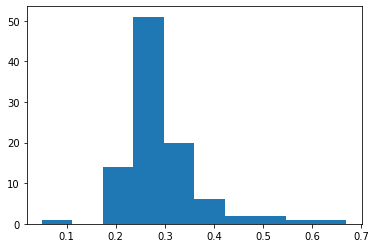

In [10]:
with loompy.connect(f_peaks) as ds:
    
    if not 'pos' in ds.ra:
        logging.info('Add pos')
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)

with loompy.connect(f_peaks, 'r') as ds:        
    dist_param = estimate_distance_parameter(ds, verbose=False)
    plt.hist(dist_param)
    alpha = np.mean(dist_param)
    logging.info(f'Set alpha at {alpha}')
    matrix = Compute_Coacces(ds, alpha=alpha)
    df, filtered_matrix = generate_ccans(matrix, ds.ra.ID)
    pkl.dump(filtered_matrix, open(pkl_file, 'wb'))

In [ ]:
with loompy.connect(f_peaks, 'r') as ds:        
    save_connections(ds, df, cicero_dir)

In [28]:
filtered_matrix = pkl.load(open(pkl_file, 'rb'))

with loompy.connect(f_cells_peaks) as ds:   
    generate_Gene_Activity(ds, filtered_matrix)

12:25:30 INFO     Starting Gene activity calculation
12:25:30 INFO     Getting matrices
/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
12:25:51 INFO     Generating file
12:25:59 INFO     Create file
12:26:53 INFO     Generating gene accessibility scores


  0%|          | 0/113769 [00:00<?, ?it/s]12:26:53 INFO     Main: float64 ssw: float32


  0%|          | 512/113769 [00:42<2:36:41, 12.05it/s]

  0%|          | 512/113769 [01:00<2:36:41, 12.05it/s]

  1%|          | 1024/113769 [01:18<2:22:50, 13.16it/s]

  1%|          | 1024/113769 [01:33<2:22:50, 13.16it/s]

  1%|▏         | 1536/113769 [01:54<2:17:02, 13.65it/s]

  1%|▏         | 1536/113769 [02:13<2:17:02, 13.65it/s]

  2%|▏         | 2048/113769 [02:30<2:14:15, 13.87it/s]

  2%|▏         | 2048/113769 [02:45<2:14:15, 13.87it/s]

  2%|▏  

NameError: name 'LinearRegression' is not defined

In [84]:
def generate_Gene_Activity(ds, matrix, dist_thresh:int=2.5e5):
    # logging.info(f'Starting Gene activity calculation')
    out_file = '/' + os.path.join(*ds.filename.split("/")[:-1], f'{ds.filename.split("/")[-2]}_GA.loom')
    
    ## Check if position coords already exist
    if not 'pos' in ds.ra:
        ds.ra.pos = np.ceil((ds.ra.Start.astype(int) + ds.ra.End.astype(int))/2).astype(int)
    
    ## Extract the TSS peaks
    TSS_pos = np.where(['TSS' in x for x in ds.ra['Detailed Annotation']])[0]

    ## Calculate the distances between associated peaks
    sources, targets = matrix.nonzero()
    weights = matrix.data.flatten()  
    pos1 = ds.ra.pos[sources].reshape((sources.shape[0],1))
    pos2 = ds.ra.pos[targets].reshape((targets.shape[0], 1))
    dists = abs(pos1-pos2).flatten()

    ## Filter out peaks that are not associated with a TSS or too far away
    TSS_pos_s = set(TSS_pos)
    v1 = [x in TSS_pos_s for x in sources]
    v2 = [x in TSS_pos_s for x in targets]
    valids = [x ^ y for x,y in zip(v1, v2)] & (dists < dist_thresh)

    ## Generate the promoter connectivity matrix
    logging.info(f'Getting matrices')
    promoter_conn_matrix = sparse.csr_matrix((weights[valids], (sources[valids],targets[valids])), shape=matrix.shape, dtype='float32')
    promoter_conn_matrix[targets[valids], sources[valids]] = weights[valids]
    promoter_conn_matrix.setdiag(1)
    promoter_conn_matrix = promoter_conn_matrix[TSS_pos,:]

    ## Distal peaks
    peaks = np.unique(np.concatenate([promoter_conn_matrix.nonzero()]))
    distal_peaks = peaks
     
    ## Weigh peaks by their connectivity to the TSS
    scaled_site_weights = np.ones(distal_peaks.shape[0])
    total_linked_site_weights = promoter_conn_matrix.tocsr()[:,distal_peaks]
    total_linked_site_weights = np.asarray(div0(1, np.sum(total_linked_site_weights, axis=1))).reshape(-1)
    total_linked_site_weights = np.diag(total_linked_site_weights)
    scaled_site_weights = total_linked_site_weights @ promoter_conn_matrix[:,distal_peaks]
    scaled_site_weights[scaled_site_weights>1] = 1
    
    return np.sum(scaled_site_weights > 0, axis=1)
        
filtered_matrix = pkl.load(open(pkl_file, 'rb'))
    
with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks.loom', 'r') as ds:
    v = generate_Gene_Activity(ds, filtered_matrix)
    
with loompy.connect('/proj/DEV_ATAC/Build_20220328_samplecor/All/All_GA.loom') as ds:
    ds.ra.NPeaks = v

16:33:35 INFO     Getting matrices
/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


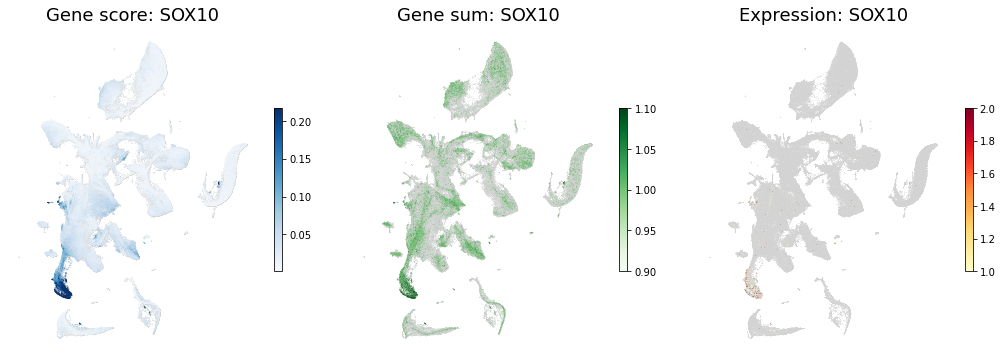

In [83]:
g = 'SOX10'
emb = 'UMAP'
s=1

f_G = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_GA.loom'
f_peaks = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_peaks.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_RNA_imputed.loom'

fig, ax = plt.subplots(1,3, figsize=(18,6))
x = ax.flatten()
with loompy.connect(f_G) as ds:        
    sel = np.where(ds.ra['Gene Name']==g)[0][0]
    v = ds.layer['pooled'][sel,:].flatten() / 25
    x = v > 0

    ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    ax[0].set_title(f'Gene score: {g}', fontsize=18)
    ax[0].axis('off')
    
with loompy.connect(f_peaks) as ds:
    sel = np.where(ds.ra['Gene Name']==g)[0]
    v = np.sum(ds[sel,:], axis=0)
    x = v > 0

    ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Greens', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[1].set_title(f'Gene sum: {g}', fontsize=18)
    ax[1].axis('off')

with loompy.connect(f_RNA) as ds:
    sel = np.where(ds.ra.Gene==g)[0][0]
    v = ds.layer['pooled'][sel,:].flatten()
    x = v > 0

    ax[2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
    im = ax[2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='YlOrRd', vmax = np.quantile(v[x], .95), marker='.', lw=0, s=s)
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title(f'Expression: {g}', fontsize=18)
    ax[2].axis('off')
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.savefig(f'/proj/DEV_ATAC/test/plots/comparison_{g}.png', dpi=300, bbox_inches='tight')


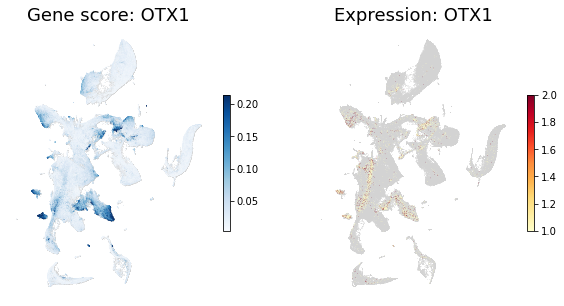

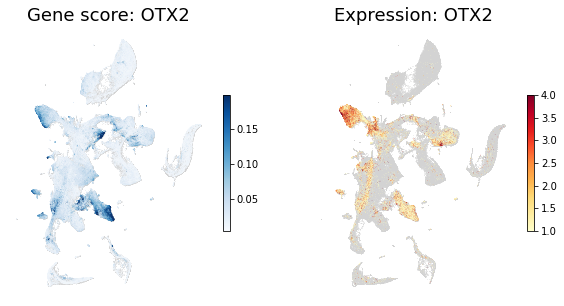

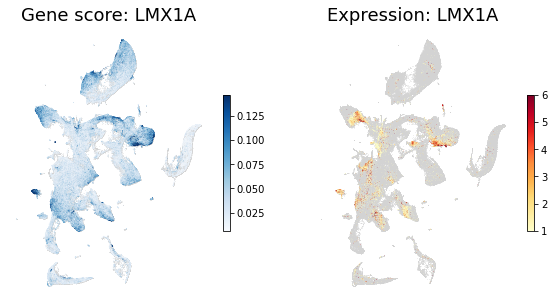

In [89]:
# genes  =  ['CLDN5', # Endo
#            'CD248', # Peri
#            'PTPRC', # Mgl
#            'DCN', # Fibroblast
#            'ALAS2', # Immature erythrocyte
#            'PAX6', # NPC
#            'RFX4', # RGL
#            'OLIG1', # OPC
#            'SOX10',
#            'AQP4', # Astro
#            'GATA3', # Interneuron progenitor Midbrain
#            'GAD2', # Interneuron
#            'SLC17A6', # VGLUT2
#            'SLC17A7', # VGLUT3
#            'PCP4', # Purkinje
#            'HOXB3', ## Hindbrain Glutamatergic
#            'EMX1', # Cortical neurons
#            'LMX1A', # Roof plate / Monoaminergic progenitors
# #            'SLC18A2' # Monoaminergic
#           ] 

genes = ['OTX1', 'OTX2', 'LMX1A']

emb = 'UMAP'
s=1

f_G = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_GA.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_RNA_imputed.loom'

for g in genes:
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    x = ax.flatten()
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
        im = ax[0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
        fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
        ax[0].set_title(f'Gene score: {g}', fontsize=18)
        ax[0].axis('off')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
        im = ax[1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='YlOrRd', vmax = np.quantile(v[x], .95), marker='.', lw=0, s=s)
        fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
        ax[1].set_title(f'Expression: {g}', fontsize=18)
        ax[1].axis('off')
        
#     plt.savefig(f'/proj/DEV_ATAC/test/plots/{g}.png', dpi=300, bbox_inches='tight')

In [84]:
with loompy.connect(f_G) as ds:        
    with loompy.connect(f_RNA) as dsr:
        X = np.zeros()
        print(ds.shape)
        print(dsr.shape)
        for i in range(ds.shape[0]):
            
            

(25893, 488935)
(36601, 488935)


In [63]:
with loompy.connect(f_G) as ds:
    
    ds['Z'] = 'float32'
    
    for (_, indexes, view) in ds.scan(axis=0, layers=["pooled"], what=["layers"]):
        X = view['pooled'][:] - mu[np.newaxis,indexes].T
        ds['Z'][indexes,:] = X / sigma[np.newaxis,indexes].T
        print(np.max(indexes))

511
1023
1535
2047
2559
3071
3583
4095
4607
5119
5631
6143
6655
7167
7679
8191
8703
9215
9727
10239
10751
11263
11775
12287
12799
13311
13823
14335
14847
15359
15871
16383
16895
17407
17919
18431
18943
19455
19967
20479
20991
21503
22015
22527
23039
23551
24063
24575
25087
25599
25892


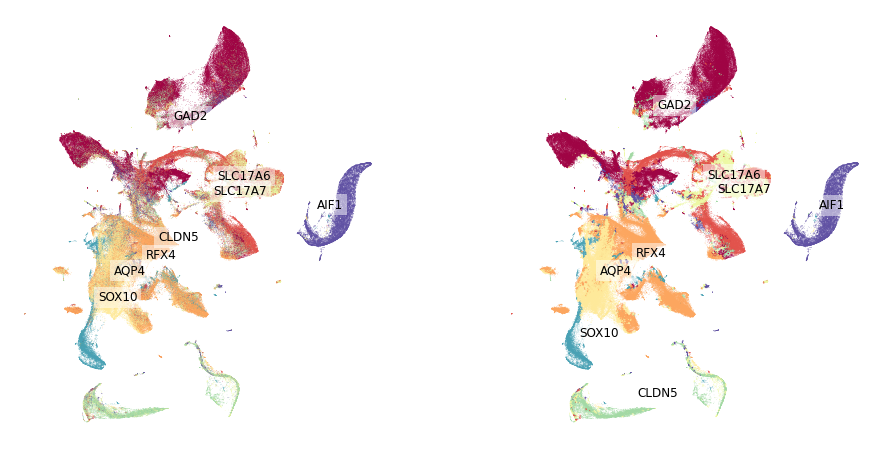

In [17]:
import loompy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from pynndescent import NNDescent

## Majority vote
# markers = ['PAX6', 'NANOG', 'CLDN5', 'AQP4', 'SOX10', 'GAD2', 'SLC17A6', 'SLC17A7', 'LUM', 'AIF1']
markers = ['RFX4', 'CLDN5', 'AQP4', 'SOX10', 'GAD2', 'SLC17A6', 'SLC17A7', 'LUM', 'AIF1']

f_G = '/proj/DEV_ATAC/Build_20220328_samplecor/All/All_GA.loom'

with loompy.connect(f_G) as ds:
    select = []
    
    for marker in markers:
        x = np.where(ds.ra['Gene Name'] == marker)[0]
        if len(x) > 1:
            select.append(x[np.argmax(ds.ra.NPeaks[x])])
        elif len(x) == 1:
            select.append(x[0])
        else:
            continue
        
    select = sorted(select)
    m = ds.ra['Gene Name'][select]
    X = ds['Z'][select,:]
    majority = np.argmax(X,axis=0)

    XY = ds.ca.UMAP
    
    nn = NNDescent(data=XY, n_jobs=-1, random_state=0)
    indices, distances = nn.query(XY, k=25)
    labels = mode(majority[indices], axis=1)[0].flatten()
    
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    
    ax[0].scatter(XY[:,0], XY[:,1], s=1,lw=0,marker='.',c=majority,cmap='Spectral');
    ax[0].set_aspect('equal');
    ax[0].axis('off')
    
    for i in np.unique(majority):
        (x, y) = np.median(XY[np.where(majority == i)[0]], axis=0)
        txt = ds.ra['Gene Name'][select[i]]
        ax[0].text(x,y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))
    
    ax[1].scatter(XY[:,0], XY[:,1], s=1,lw=0,marker='.',c=labels,cmap='Spectral');
    ax[1].set_aspect('equal');
    ax[1].axis('off')
    
    for i in np.unique(labels):
        (x, y) = np.median(XY[np.where(labels == i)[0]], axis=0)
        txt = ds.ra['Gene Name'][select[i]]
        ax[1].text(x,y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))
    

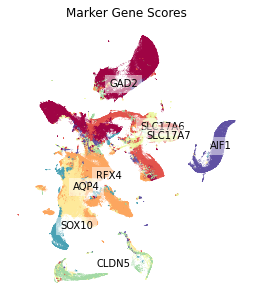

In [20]:
with loompy.connect(f_G) as ds:

    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(XY[:,0], XY[:,1], s=1,lw=0,marker='.',c=labels,cmap='Spectral');
    ax.set_aspect('equal');
    ax.axis('off')
    
    for i in np.unique(labels):
        (x, y) = np.median(XY[np.where(labels == i)[0]], axis=0)
        txt = ds.ra['Gene Name'][select[i]]
        ax.text(x,y, txt, fontsize=10, bbox=dict(facecolor='white', alpha=0.5, ec='none'))
        
    plt.title(f'Marker Gene Scores')
    plt.savefig('/home/camiel/misc/fig1/Markers_UMAP.png', dpi=300, bbox_inches='tight')

/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


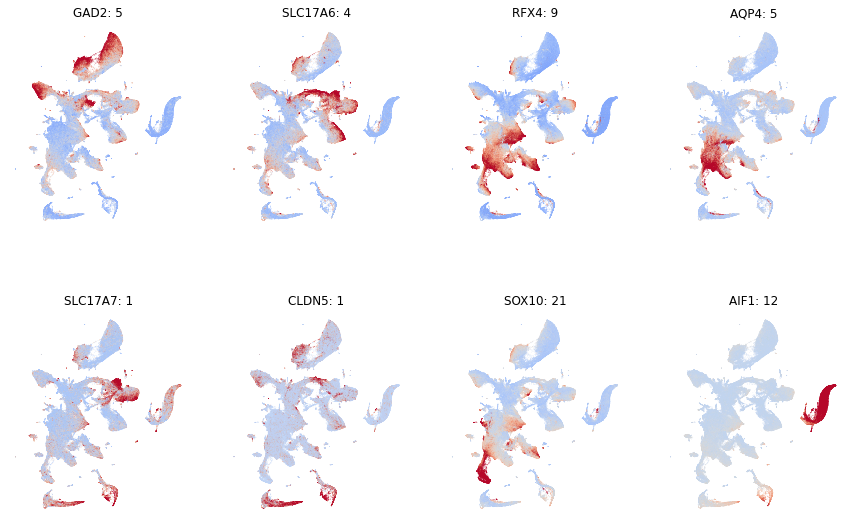

In [22]:
with loompy.connect(f_G) as ds:

    columns = 4
    plt.figure(figsize=(15,15))
    for i, x in enumerate(np.unique(majority)):
        s = select[x]
        m = ds.ra['Gene Name'][s]
        v = ds['Z'][s,:]            
        plt.subplot(len(select) / columns + 1, columns, i + 1)

        plt.scatter(ds.ca.UMAP[:,0],ds.ca.UMAP[:,1], lw=0,s=1,marker='.', c=v, cmap='coolwarm', vmin=-2, vmax=2)
        
        plt.title(ds.ra['Gene Name'][s] + ': ' + ds.ra.NPeaks[s].astype(str))
        plt.axis('off')
        plt.gca().set_aspect('equal')

In [42]:
g = 'OLIG1'

with loompy.connect(f_G) as ds:
    x = np.where(ds.ra['Gene Name']==g)[0]
    print(ds.ra.NPeaks[x])

[9]


/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


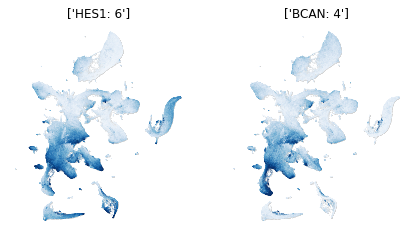

In [21]:
# genes = ['PAX3', 'CXCR4', 'TNC', 'NTS', 'MSX1', 'RFX4', 'SOX2']
genes = ['HES1', 'BCAN']

with loompy.connect(f_G) as ds:

    columns = 4
    plt.figure(figsize=(15,15))
    XY = ds.ca.UMAP
    for i, g in enumerate(genes):
        sel = np.where(ds.ra['Gene Name']==g)[0]
        if len(sel) > 1:
            sel = sel[np.argmax(ds.ra.NPeaks[sel])]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        plt.subplot(len(select) / columns + 1, columns, i + 1)

        plt.scatter(XY[:,0], XY[:,1], lw=0,s=1,marker='.', c='lightgray')        
        plt.scatter(XY[v>0,0], XY[v>0,1], lw=0,s=1,marker='.', c=v[v>0], cmap='Blues', vmax=np.quantile(v[v>0], .99))
        
        plt.title(ds.ra['Gene Name'][sel] + ': ' + ds.ra.NPeaks[sel].astype(str))
        plt.axis('off')
        plt.gca().set_aspect('equal')

[11903]
[8858]
[14633]
[1511]
[10258]
[21233]
(488935,)


/home/camiel/anaconda3/envs/GL_test/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


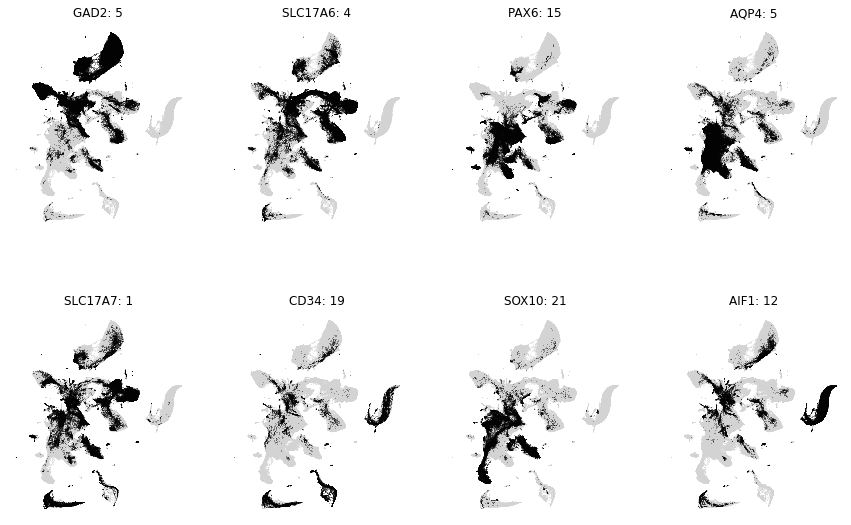

In [118]:
# ## Majority vote
# markers = ['PAX6', 'NANOG', 'CD34', 'AQP4', 'SOX10', 'GAD2', 'SLC17A6', 'SLC17A7', 'LUM', 'AIF1']

# with loompy.connect(f_G) as ds:
#     select = []
    
#     for marker in markers:
#         x = np.where(ds.ra['Gene Name'] == marker)[0]
#         if len(x) > 1:
#             select.append(x[np.argmax(ds.ra.NPeaks[x])])
#         elif len(x) == 1:
#             print(x)
#             select.append(x[0])
#         else:
#             continue
        
#     select = sorted(select)
#     m = ds.ra['Gene Name'][select]
#     X = ds['Z'][select,:]
#     majority = np.argmax(X,axis=0)
#     print(majority.shape)

#     columns = 4
#     plt.figure(figsize=(15,15))
#     for i, x in enumerate(np.unique(majority)):
#         s = select[x]
#         x = np.where(majority==x)[0]
            
#         plt.subplot(len(select) / columns + 1, columns, i + 1)

#         plt.scatter(ds.ca.UMAP[:,0],ds.ca.UMAP[:,1], lw=0,s=1,marker='.',c='lightgray')
        
#         plt.title(ds.ra['Gene Name'][s] + ': ' + ds.ra.NPeaks[s].astype(str))
#         plt.axis('off')
#         plt.gca().set_aspect('equal')

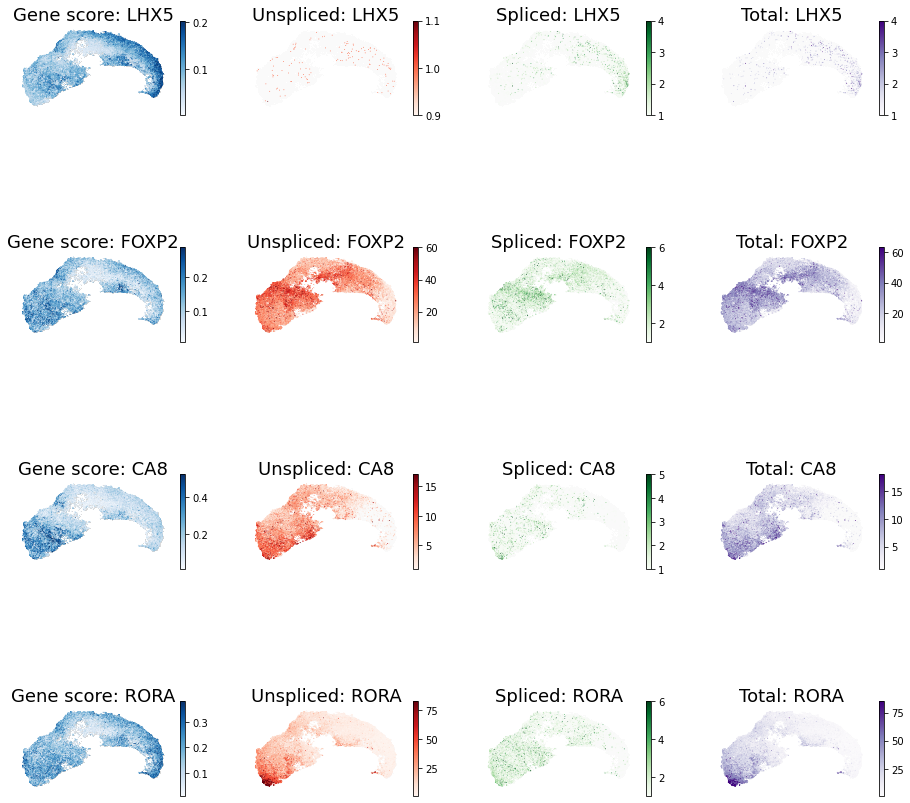

In [87]:
# genes = ['PTF1A', 'NHLH2', 'LHX5', 'POU4F1', ## Prog
#          'GAD1', 'GAD2', 'FOXP2', 'SLC32A1', ## Interneuron
#          'CALB1', 'PCP4', 'CA8', 'RORA' ## Purk
# ]

genes = ['LHX5', ## Prog
         'FOXP2', ## Interneuron
         'CA8', 'RORA' ## Purk
]
         
nrows = len(genes)

emb = 'UMAP_jaccard'
s=3

f_G = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_GA.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_RNA_imputed.loom'

fig, ax = plt.subplots(nrows,4, figsize=(16,4*nrows))

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=s)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=s)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')
        ax[i,0].set_aspect('equal')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['unspliced_pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Reds', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Unspliced: {g}', fontsize=18)
        ax[i,1].axis('off')
        ax[i,1].set_aspect('equal')

        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['spliced_pooled'][sel,:].flatten()
        x = v > 0

        ax[i,2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Greens', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,2], orientation='vertical', shrink=.5)
        ax[i,2].set_title(f'Spliced: {g}', fontsize=18)
        ax[i,2].axis('off')
        ax[i,2].set_aspect('equal')

        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,3].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='#fafafa', marker='.', lw=0, s=s)
        if np.sum(x) > 0:
            im = ax[i,3].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], vmax= np.quantile(v[x], .99), cmap='Purples', marker='.', lw=0, s=s)
            fig.colorbar(im, ax=ax[i,3], orientation='vertical', shrink=.5)
        ax[i,3].set_title(f'Total: {g}', fontsize=18)
        ax[i,3].axis('off')
        ax[i,3].set_aspect('equal')

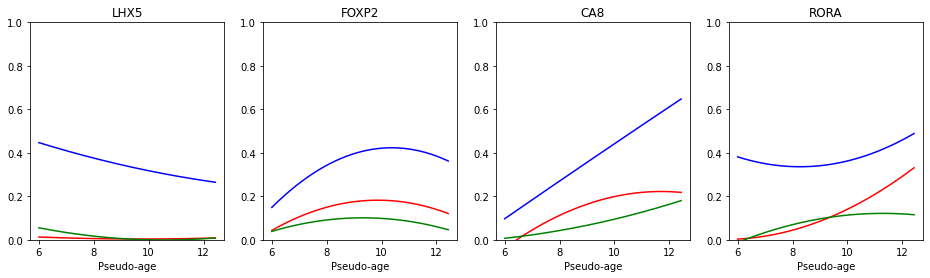

In [90]:
# genes = ['PTF1A', 'NHLH2', 'LHX5', 'POU4F1', ## Prog
#          'GAD1', 'GAD2', 'FOXP2', 'SLC32A1', ## Interneuron
#          'CALB1', 'PCP4', 'CA8', 'RORA' ## Purk
# ]

nrows = int(np.ceil(len(genes)/4))
s = 10

fig, ax = plt.subplots(nrows,4,figsize=(16,4*nrows))
ax = ax.flatten()

f_G = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_GA.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/Purk/Purk_RNA.loom'

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:   
        x = np.where(ds.ca.Chemistry=='multiome_atac')[0]
        ordered = np.argsort(ds.ca.PseudoAge[x])
        Age = np.clip(ds.ca.PseudoAge[x][ordered], 6,13)
        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        v = v[x][ordered] / np.max(v[x])
        
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='blue')
#         ax[i].scatter(Age, v, marker='.', lw=0, s=1)
        ax[i].set_title(g)
        
    with loompy.connect(f_RNA) as ds:
        ordered = np.argsort(ds.ca.PseudoAge)
        Age = np.clip(ds.ca.PseudoAge[ordered], 6,13)
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['unspliced'][sel,:].flatten()
        v = v[ordered] / np.max(v)
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='red')
        
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['spliced'][sel,:].flatten()
        v = v[ordered] / np.max(v)
        z = np.polyfit(Age, v, 2)
        p = np.poly1d(z)
        
        ax[i].plot(Age, p(Age), c='green')
        ax[i].set_ylim((0,1))
        
        ax[i].set_xlabel('Pseudo-age')

In [35]:
g = 'TFAP'
emb = 'TSNE'
with loompy.connect(f_G) as ds:        
    genes = ds.ra['Gene Name'][np.where([g in x for x in ds.ra['Gene Name']])[0]]
    print(genes)
    print(ds.ra['Gene Name'][ds.ra['Gene Name']==g])
    print(ds.shape)
    print(ds.layers.keys())
    x = np.flatnonzero(np.core.defchararray.find(ds.ra['Gene Name'].astype(str),g)!=-1)
    print(f"exact: {ds.ra['Gene Name'][ds.ra['Gene Name']==g]}")
    print(sorted(ds.ra['Gene Name'][x]))

['TFAP4' 'TFAP4' 'TFAP2E' 'TFAP2C' 'TFAP2C' 'TFAP2A-AS2' 'TFAP2A' 'TFAP2A'
 'TFAP2A']
[]
(27213, 56174)
['', 'norm', 'pooled']
exact: []
['TFAP2A', 'TFAP2A', 'TFAP2A', 'TFAP2A-AS2', 'TFAP2C', 'TFAP2C', 'TFAP2E', 'TFAP4', 'TFAP4']


In [59]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/Purk/Purk_peaks.loom') as ds:
    print(ds.shape)
    X = np.array([x.split(' ')[0] for x in ds.ra.Annotation])
    TSS_an = np.where(X=='promoter-TSS')[0] ## Fix to be the closest peak to TSS
    TSS_dis = np.where(abs(ds.ra['Distance to TSS'].astype(int))<250)[0]

    print(len(TSS_dis))
    valid_genes = ds.ra['Gene Name'][TSS_dis]
    print(len(np.unique(valid_genes)))

    print(len(TSS_an))
    valid_genes = ds.ra['Gene Name'][TSS_an]
    print(len(np.unique(valid_genes)))

(460591, 56174)
21304
18940
27221
22417


In [66]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/Purk/Purk_peaks.loom') as ds:
    all_genes = np.unique(ds.ra['Gene Name'])
    print(len(all_genes))
    
    proms = []
    for g in tqdm(all_genes):
        x = np.where(ds.ra['Gene Name']==g)[0]
        dist = abs(ds.ra['Distance to TSS'][x].astype(int))
        mn = np.min(dist)
        if mn < 500:
            proms.append(x[dist==mn])
        
    print(len(proms))

  0%|          | 0/46964 [00:00<?, ?it/s]

46964


100%|██████████| 46964/46964 [24:19<00:00, 32.17it/s]

22875


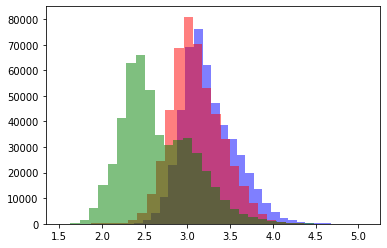

In [128]:
with loompy.connect(f_RNA) as ds:
# #     tot = ds['pooled'].map([np.sum], axis=1)[0]
#     U = ds['unspliced_pooled'].map([np.sum], axis=1)[0]
#     S = ds['spliced_pooled'].map([np.sum], axis=1)[0]
    plt.hist(np.log10(tot+1), bins =30, alpha=.5, color='blue')
    plt.hist(np.log10(U+1), bins =30, alpha=.5, color='red')
    plt.hist(np.log10(S+1), bins =30, alpha=.5, color='green')

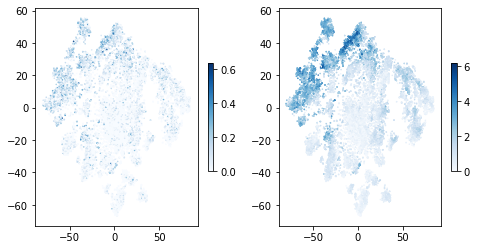

In [102]:
g = 'SLC6A5'

with loompy.connect(f_G) as ds:        
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    s = np.where(ds.ra['Gene Name']==g)[0][0]
    im1 = ax[0].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds['norm'][s,:], cmap='Blues', marker='.', s=1)
    im2 = ax[1].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], c=ds['pooled'][s,:], cmap='Blues', marker='.', s=1)
    fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=.5)
    fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=.5)

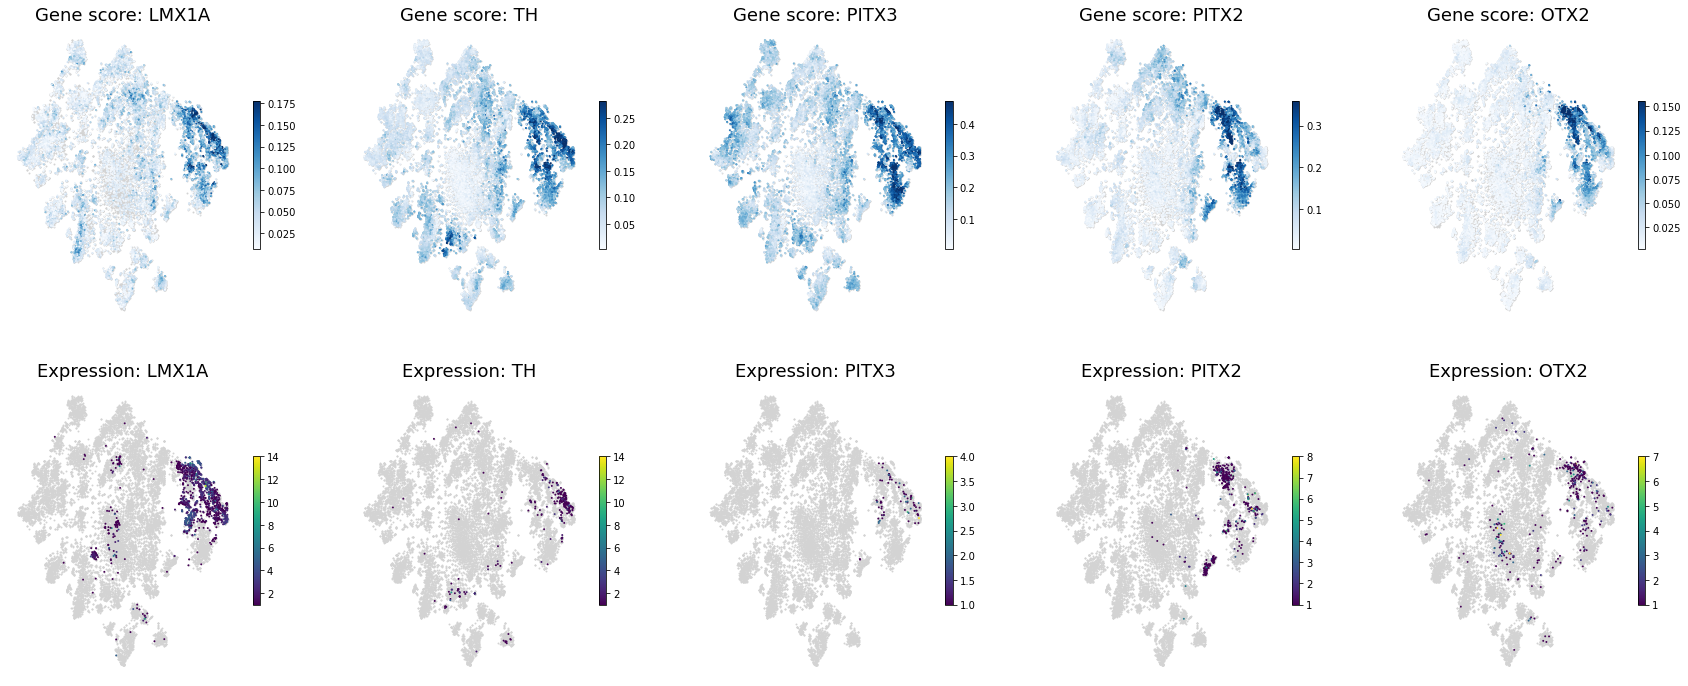

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import loompy

genes = ['LMX1A', 'TH', 'PITX3', 'PITX2', 'OTX2']
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/Build_20220131/TH/TH_GA.loom'
f_prom = '/proj/DEV_ATAC/Build_20220131/TH/TH_prom.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/TH/TH_RNA_imputed.loom'

fig, ax = plt.subplots(2, len(genes), figsize=(6*len(genes),12))
ax = ax.T

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Expression: {g}', fontsize=18)
        ax[i,1].axis('off')
    
# fig.savefig('/home/camiel/misc/Gene_score_expression.png')

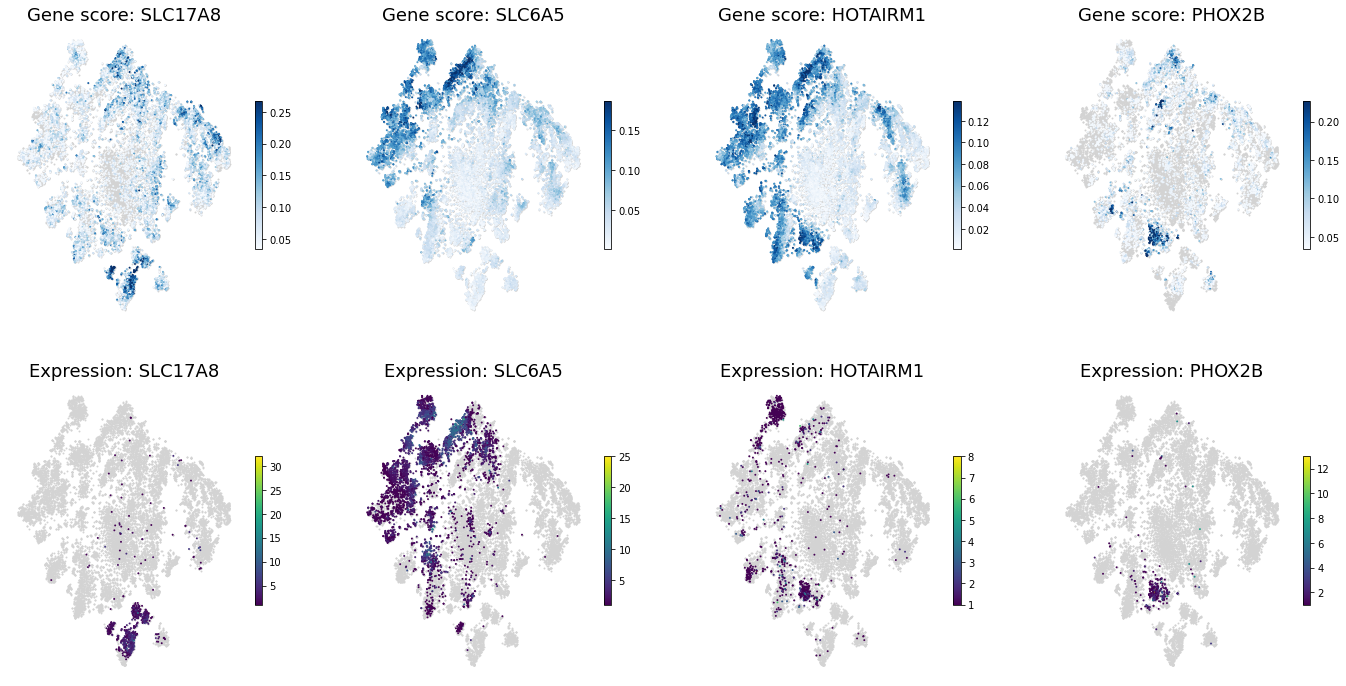

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import loompy

genes = ['SLC17A8', 'SLC6A5', 'HOTAIRM1', 'PHOX2B']
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/Build_20220131/TH/TH_GA.loom'
f_prom = '/proj/DEV_ATAC/Build_20220131/TH/TH_prom.loom'
f_RNA = '/proj/DEV_ATAC/Build_20220131/TH/TH_RNA_imputed.loom'

fig, ax = plt.subplots(2, len(genes), figsize=(6*len(genes),12))
ax = ax.T

for i, g in enumerate(genes):
    with loompy.connect(f_G) as ds:        
        sel = np.where(ds.ra['Gene Name']==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten() / 25
        x = v > 0

        ax[i,0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='Blues', vmax = np.quantile(v, .99), marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,0], orientation='vertical', shrink=.5)
        ax[i,0].set_title(f'Gene score: {g}', fontsize=18)
        ax[i,0].axis('off')

    with loompy.connect(f_RNA) as ds:
        sel = np.where(ds.ra.Gene==g)[0][0]
        v = ds.layer['pooled'][sel,:].flatten()
        x = v > 0

        ax[i,1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=15)
        im = ax[i,1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', marker='.', lw=0, s=15)
        fig.colorbar(im, ax=ax[i,1], orientation='vertical', shrink=.5)
        ax[i,1].set_title(f'Expression: {g}', fontsize=18)
        ax[i,1].axis('off')
    
# fig.savefig('/home/camiel/misc/Gene_score_expression.png')

In [84]:
g = 'DAB1'
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/test/test_GA.loom'
with loompy.connect(f_G) as ds:        
    genes = ds.ra['Gene Name'][np.where([g in x for x in ds.ra['Gene Name']])[0]]
    print(genes)
    print(ds.ra['Gene Name'][ds.ra['Gene Name']==g])
    print(ds.shape)
    print(ds.layers.keys())
    x = np.flatnonzero(np.core.defchararray.find(ds.ra['Gene Name'].astype(str),g)!=-1)
    print(f"exact: {ds.ra['Gene Name'][ds.ra['Gene Name']==g]}")
    print(sorted(ds.ra['Gene Name'][x]))

['DAB1']
['DAB1']
(21344, 122963)
['', 'pooled']
exact: ['DAB1']
['DAB1']


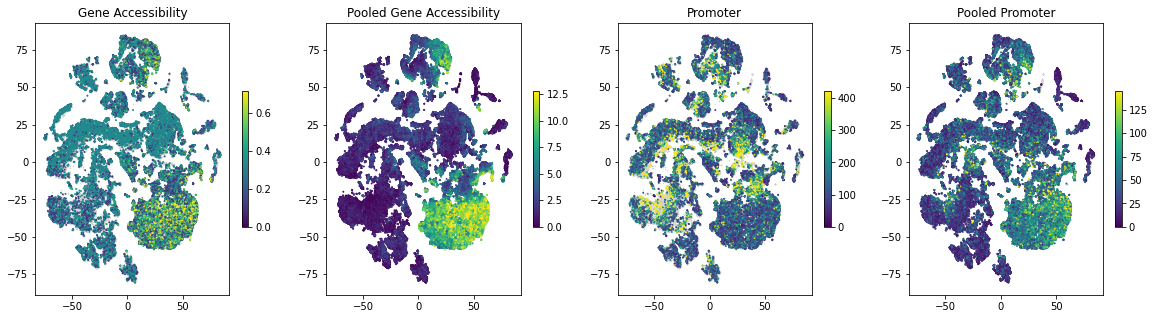

In [90]:
gene = 'TNC'
emb = 'TSNE'
f_G = '/proj/DEV_ATAC/test/test_GA.loom'
f_prom_test = '/proj/DEV_ATAC/Build_20211016/Cerebellum/Cerebellum_prom.loom'
fig, ax = plt.subplots(1,4, figsize=(20,5))

with loompy.connect(f_G) as ds:        
    v = ds.layer[''][ds.ra['Gene Name'] == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[0].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[0].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[0], orientation='vertical', shrink=.5)
    
    v = ds['pooled'][ds.ra['Gene Name'] == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[1].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[1].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=.5)
    ax[0].set_title('Gene Accessibility')
    ax[1].set_title('Pooled Gene Accessibility')
    
with loompy.connect(f_prom_test) as ds:
    v = ds.layer['CPM'][ds.ra.Gene == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[2].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[2].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=.5)
    ax[2].set_title('Promoter')
    
    v = ds.layer['pooled_CPM'][ds.ra.Gene == gene,:].flatten()
    x = np.where(v > 0)[0]
    ax[3].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
    im = ax[3].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v, .99), vmin = np.quantile(v, .01), marker='.', lw=0, s=15)
    fig.colorbar(im, ax=ax[3], orientation='vertical', shrink=.5)
    ax[3].set_title('Pooled Promoter')

In [46]:
import pickle as pkl

df = pkl.load(open('/proj/DEV_ATAC/Build_20220328_samplecor/All/cicero/CCANs.pkl', 'rb'))
print(df.shape)
# df = pkl.load(open('/proj/DEV_ATAC/Build_20220131/All/cicero/CCANs.pkl', 'rb'))
# print(df.shape)

(445462, 4)


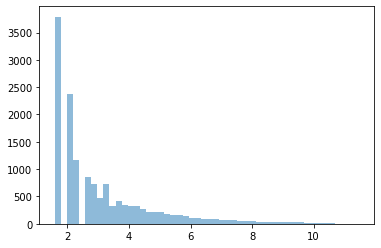

In [61]:
from collections import Counter

values = np.array([v for k,v in Counter(df.CCAN).items()])
plt.hist(np.log2(values+1), bins=50, alpha=.5);

In [70]:
np.sum(values>10)

4162